# Final Project: Predicting House Prices Using Random Forest Regression

For the final project I will use the House Prices dataset from Kaggle which comprises of residental homes in Ames, Iowa.
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

## Project Summary

This project uses Random Forest Regression to predict house prices using the Kaggle House Prices dataset. The dataset includes 79 features relating to different aspects of the houses. The the goal of this project is to determine what features are most important to the pricing of houses and to accurately predict housing prices based on the most important features.
***

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Step 1: Load Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Training shape:', train.shape)
print('Testing shape:', test.shape)

train.head()

Training shape: (1460, 81)
Testing shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We can see that there are a lot of zeroes and NaN values, so we should remove these missing values.

### Step 2: Clean Data

In [3]:
missing = train.isnull().sum().sort_values(ascending = False)
print('Missing Vals\n', missing[missing > 0])

Missing Vals
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


There are several features that have more than one hundered missing values, so we will remove thaem for cleaner data.

In [4]:
train.drop(columns = missing[missing > len(train) * 0.3].index, inplace = True)
test.drop(columns = missing[missing > len(train) * 0.3].index, inplace = True)
print('Dropped features:', missing[missing > len(train) * 0.3].index)

Dropped features: Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')


The remaining missing values can be filled with the median and mode for the numerical and categorical columns respectively (numbered and named). Using the median value reduces the effect that outliers has on the taining and test data.

In [5]:
# Impute remaining missing values
n_cols = train.select_dtypes(include = ['float64', 'int64']).columns
for column in n_cols:
    if column != "SalePrice":
        test[column].fillna(test[column].median(), inplace = True)
    train[column].fillna(train[column].median(), inplace = True)

c_cols = train.select_dtypes(include=['object']).columns
for column in c_cols:
    train[column].fillna(train[column].mode()[0], inplace = True)
    if column in test.columns:
        test[column].fillna(train[column].mode()[0], inplace = True)
        
print(f"Train: {train.isnull().sum().sum()}, Test: {test.isnull().sum().sum()}")

Train: 0, Test: 0


No NULL values remain, so we can continue on.

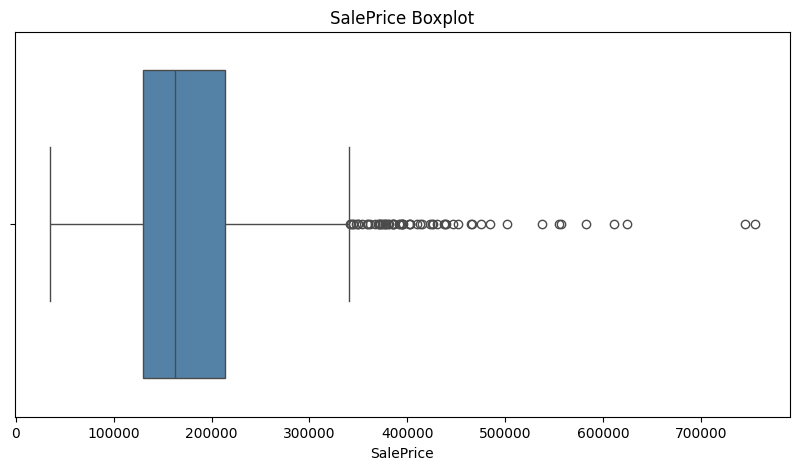

In [6]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = train['SalePrice'], color = 'steelblue')
plt.title('SalePrice Boxplot')
plt.show()

There are many outliers still left after cleaning. Removal of these outliers will give us better predictions. We can remove the 95th percentile which will remove most of the outliers.

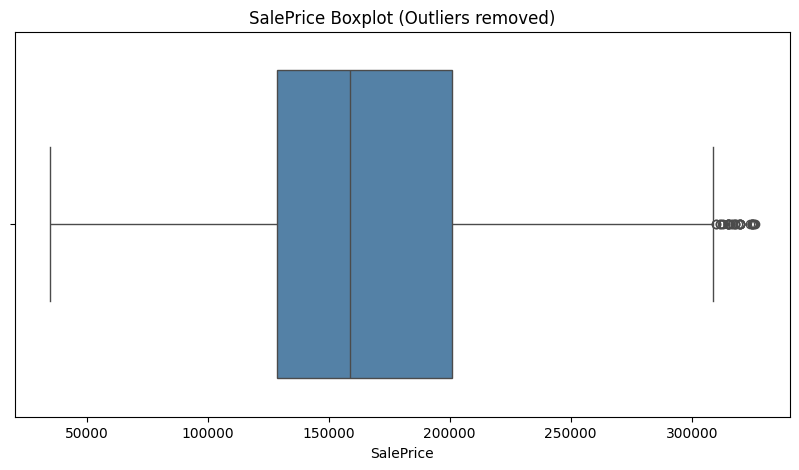

In [7]:
train = train[train['SalePrice'] < (train['SalePrice'].quantile(0.95))]

plt.figure(figsize = (10, 5))
sns.boxplot(x = train['SalePrice'], color = 'steelblue')
plt.title('SalePrice Boxplot (Outliers removed)')
plt.show()

### Step 3: Data Analysis

Here is a distribution of the SalePrice feature in the dataset. The majority of housing prices look to be around $125,000.

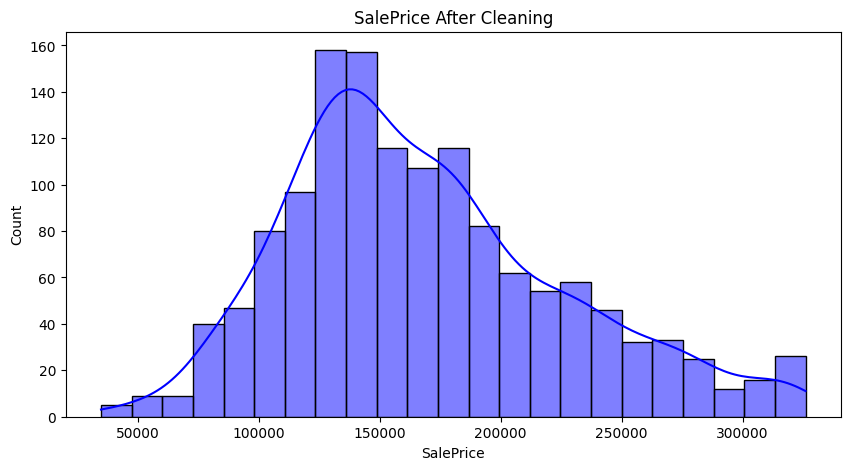

In [8]:
plt.figure(figsize = (10, 5))
sns.histplot(train['SalePrice'], kde = True, color = 'blue')
plt.title('SalePrice After Cleaning')
plt.show()

Top 5 Features:
 SalePrice      1.000000
OverallQual    0.781060
GrLivArea      0.653331
GarageCars     0.625293
GarageArea     0.602064
Name: SalePrice, dtype: float64


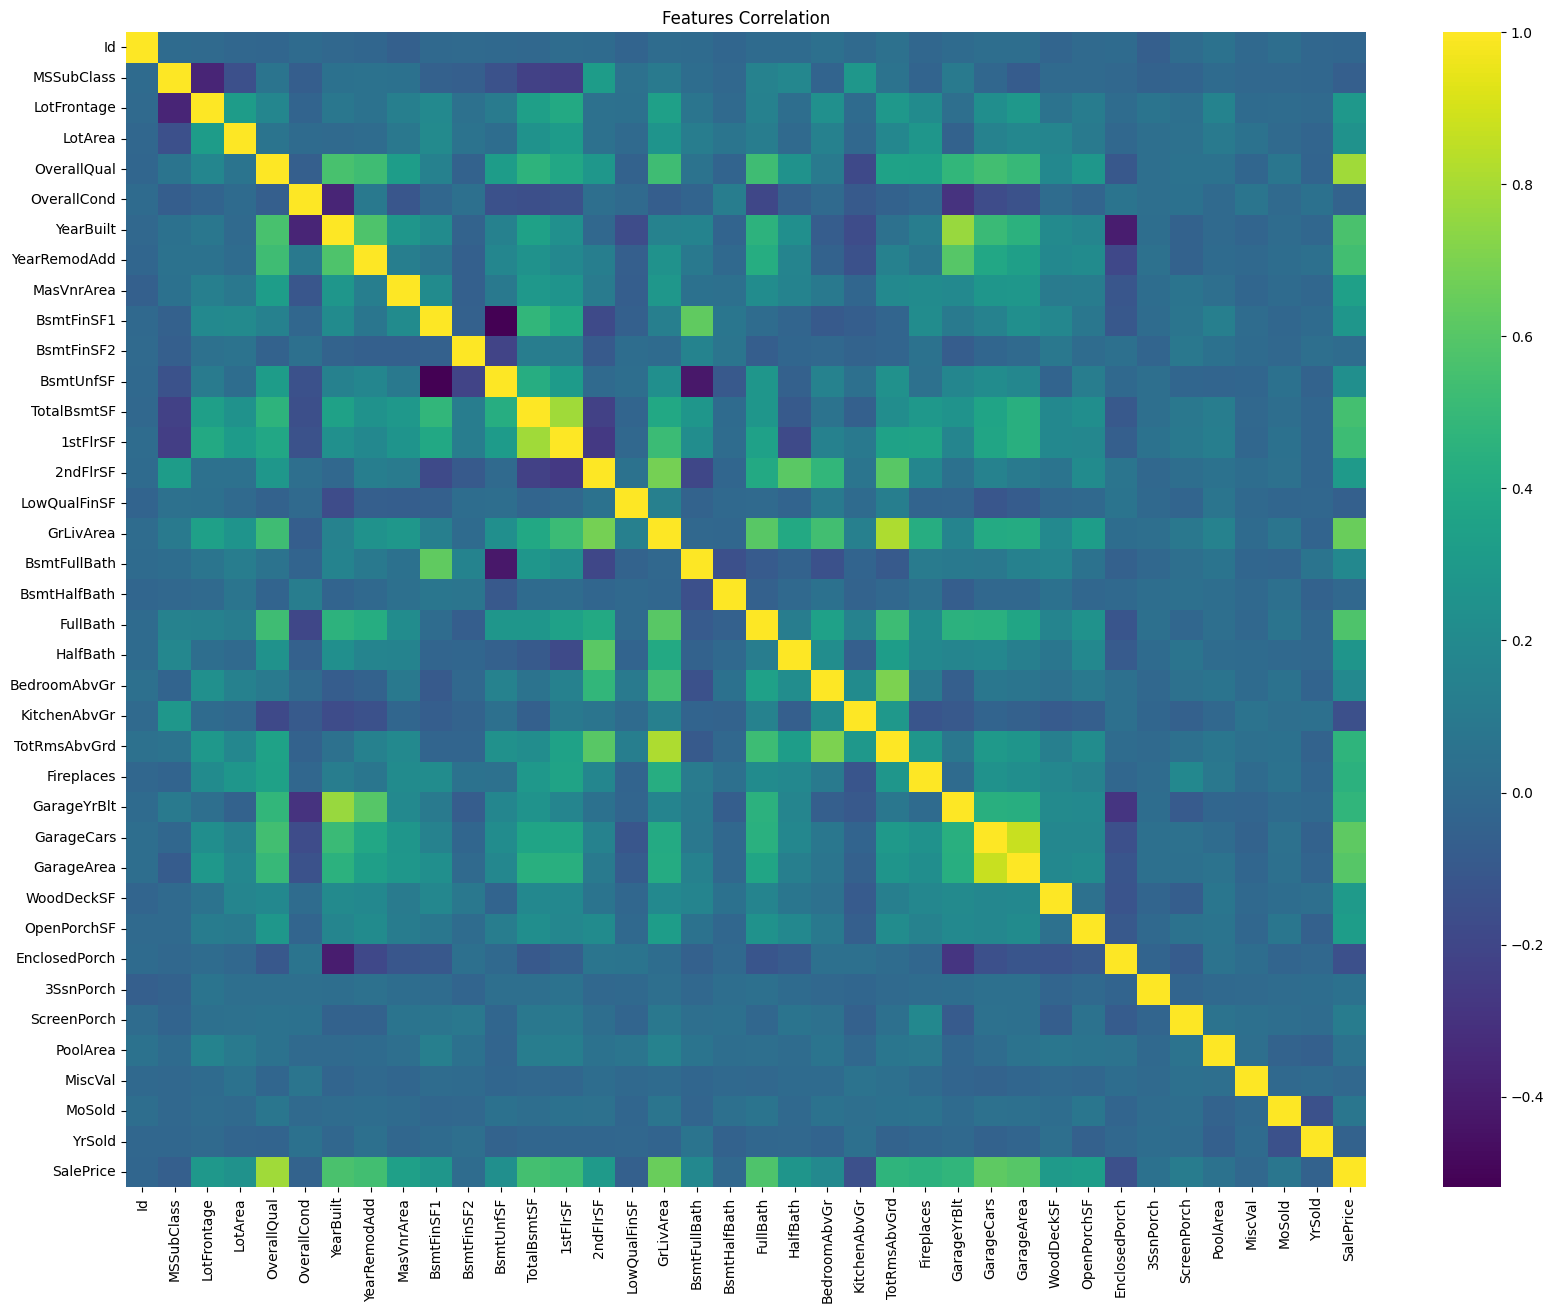

In [9]:
correlation = train.corr()['SalePrice'].sort_values(ascending = False)
print('Top 5 Features:\n', correlation.head(5))

plt.figure(figsize = (20, 15))
sns.heatmap(train.corr(), annot = False, cmap = 'viridis')
plt.title('Features Correlation')
plt.show()


We can see from the printout of the highest correlated features, OverallQual (Overall material and finish quality) had the highest correlation with increasing house price, showing that it's the most important feature when appraising a house. Other notable feature are GirLivArea (Above ground living area square feet), GarageCars (Size of garage in car capacity), and GarageArea (Size of garage in square feet).

### Step 4: Data Preprocessing

Prepare the data to be trained using Random Forest Regression

In [10]:
category = train.select_dtypes(include = ['object']).columns
label = LabelEncoder()

for col in category:
    train[col] = label.fit_transform(train[col])
    test[col] = label.transform(test[col])

In [11]:
X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Step 5: Train Model With Random Forest Regressor

Before running our Random Forest Regressor, we need to find the best values for n_estimators, max_depth, and min_samples_split. Increasing the number of entries for each of these parameters will only make the GridSearchCV run longer (2+ mins), so we're keeping it to a minimum.

In [ ]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 6, 8, 10]
}

model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)

search = GridSearchCV(model, params, cv = 3, scoring = 'neg_mean_squared_error', verbose = 1, n_jobs = -1)
search.fit(X_train, y_train)

best = search.best_estimator_
print('Best Parameters:', search.best_params_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 400}


After waiting to get the best model, these are the results.

In [ ]:
ypred = best.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, ypred):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, ypred)):.2f}, R²: {r2_score(y_test, ypred):.2f}')

MAE: 13736.52, RMSE: 19424.29, R²: 0.89


### Step 6: Results

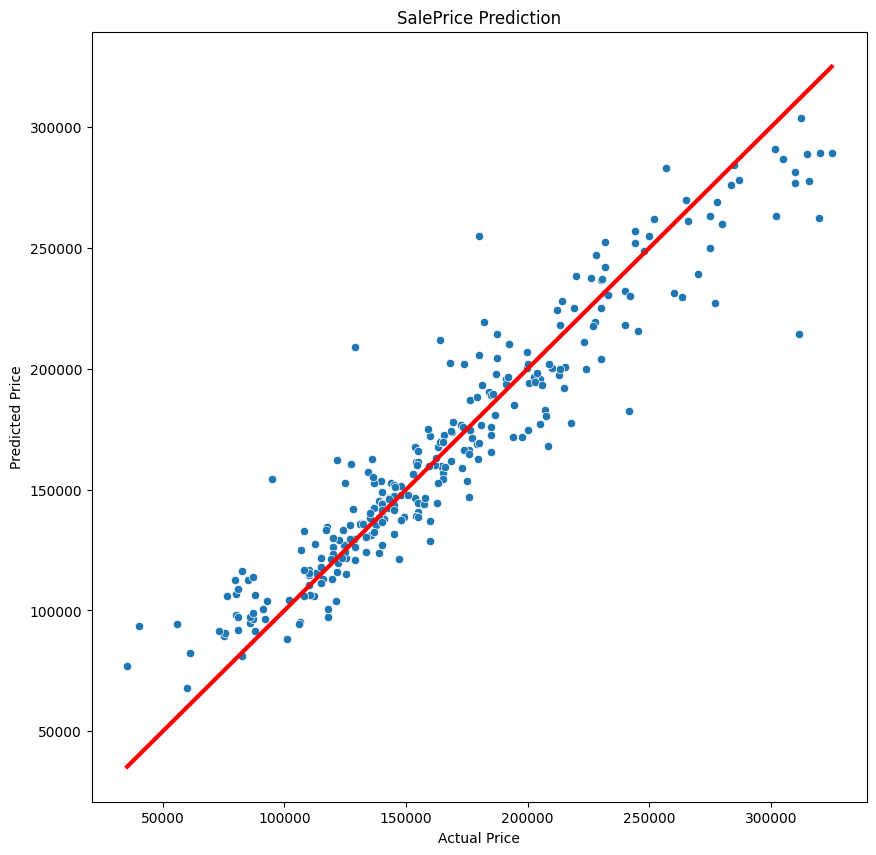

In [14]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x = y_test, y = ypred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red', lw = 3)
plt.title('SalePrice Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

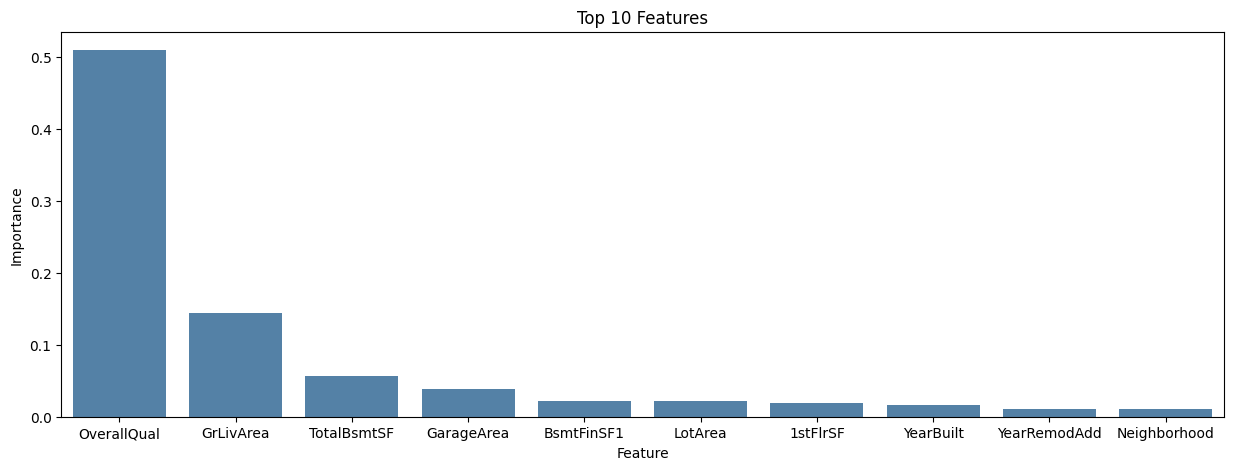

In [15]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (15, 5))
sns.barplot(x = 'Feature', y = 'Importance', data = importance.head(10), color = 'steelblue')
plt.title('Top 10 Features')
plt.show()

This plot differs from our results in step three, which don't show TotalBsmtSF (Total square feet of basement area) as the third most important feature. Regardless, all of these features are very important in their own right.

***
### Summary

We can see from the scatterplot above that the predicted price of a home matches fairly close to the actual price of a home listed in the dataset. There are outliers in the prediction, with cheaper houses being predicted to have higher prices, and more expensive houses predicted to be cheaper. 

We can also see from the barplot above that the OverallQual is the most important feature by far in the dataset, having an important rating of ~0.5. Only one other feature has an importance rating above 0.1, which is GrLivArea, with the rest of the top features being somewhat close to each other in terms of importance. It is interesting to see that things like Neighborhood and YearBuilt don't have a higher importance rating.

To improve the notebook in the future, a comparison of different regression techniques can be added to determine the best regression type to use. Another thing that could be done is instead of dropping columns with NULL values, replace the NULL values with a zero so that we can see the importance of the features that were dropped during the data cleaning step.